In [1]:
# === Cell 0 — Quick Start (Sidekick / Stage-3) ===============================
#   Artur/runs_full_qae_2L2T/q4_l2t2/L1/4q_2l_2t_1ls_01.json
#   Artur/runs_full_qae_2L2T/q4_l2t2/L3/4q_2l_2t_3ls_01.json

import os, glob, json

def _looks_like_sidekick_json(path):
    try:
        with open(path, "r", encoding="utf-8") as f:
            J = json.load(f)
        P = J.get("parameters", {})
        return ("psi_stage3" in P) and ("phi_stage1" in P)
    except Exception:
        return False

def _collect_roots():
    """Find all .../runs_halfqae* dirs under likely bases (., Artur/, .., ../..)."""
    bases = [".", "Artur", "..", "../.."]
    roots = set()
    for base in bases:
        base_abs = os.path.abspath(base)
        for d in glob.glob(os.path.join(base_abs, "runs_halfqae*")):
            if os.path.isdir(d):
                roots.add(os.path.abspath(d))
        art = os.path.join(base_abs, "Artur")
        if os.path.isdir(art):
            for d in glob.glob(os.path.join(art, "runs_halfqae*")):
                if os.path.isdir(d):
                    roots.add(os.path.abspath(d))
    return sorted(roots)

def _discover_models(roots, pattern="**/*.json"):
    d = {}
    skipped = 0
    for r in roots:
        for p in glob.glob(os.path.join(r, pattern), recursive=True):
            if not p.lower().endswith(".json"):
                continue
            if not _looks_like_sidekick_json(p):
                skipped += 1
                continue
            tag = os.path.splitext(os.path.basename(p))[0]  # filename stem
            base = tag; k = 1
            while tag in d:
                k += 1; tag = f"{base}_{k}"
            d[tag] = os.path.abspath(p)
    return d, skipped

# ---- Auto-discover everything under Artur/runs_full_qae_*
DISCOVERED_ROOTS = _collect_roots()
MODEL_PATHS = {}  # manual

auto, skipped = _discover_models(DISCOVERED_ROOTS)
for k, v in auto.items():
    if k not in MODEL_PATHS:
        MODEL_PATHS[k] = v

if DISCOVERED_ROOTS:
    try:
        ARTUR_ROOT = os.path.commonpath([os.path.dirname(r) for r in DISCOVERED_ROOTS])
    except ValueError:
        ARTUR_ROOT = os.path.dirname(DISCOVERED_ROOTS[0])
else:
    ARTUR_ROOT = os.path.abspath(".")

print(f"Discovery roots: {len(DISCOVERED_ROOTS)}")
for r in DISCOVERED_ROOTS[:6]:
    print("  •", r)
print(f"Models registered: {len(MODEL_PATHS)} (skipped non-matching JSONs: {skipped})")
if MODEL_PATHS:
    first_few = list(MODEL_PATHS.items())[:5]
    for name, path in first_few:
        print(f"  ✓ {name}  <- {path}")

# ── Evaluation knobs ─────────────────────────────────────────────────────────
EVAL_SIGMA = 0.1          # or "model" to use each model's training sigma
N_EVAL_WINDOWS = 20       # per dataset per model

Discovery roots: 1
  • c:\Users\artur\Desktop\QAE\Artur\runs_halfqae
Models registered: 40 (skipped non-matching JSONs: 0)
  ✓ 4q_2l_2t_1ls_01  <- c:\Users\artur\Desktop\QAE\Artur\runs_halfqae\q4_l2t2\L1\4q_2l_2t_1ls_01.json
  ✓ 4q_2l_2t_1ls_02  <- c:\Users\artur\Desktop\QAE\Artur\runs_halfqae\q4_l2t2\L1\4q_2l_2t_1ls_02.json
  ✓ 4q_2l_2t_1ls_03  <- c:\Users\artur\Desktop\QAE\Artur\runs_halfqae\q4_l2t2\L1\4q_2l_2t_1ls_03.json
  ✓ 4q_2l_2t_1ls_04  <- c:\Users\artur\Desktop\QAE\Artur\runs_halfqae\q4_l2t2\L1\4q_2l_2t_1ls_04.json
  ✓ 4q_2l_2t_1ls_05  <- c:\Users\artur\Desktop\QAE\Artur\runs_halfqae\q4_l2t2\L1\4q_2l_2t_1ls_05.json


In [2]:
# === Cell 1 — Imports & utilities ===========================================
import os, re, json, math, time, hashlib, warnings, glob
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pennylane as qml
from pennylane import numpy as pnp

np.set_printoptions(suppress=True, precision=6)
plt.rcParams["figure.figsize"] = (6.8, 4.2)

# ---------- scaling & angles ----------
def values_to_v01(v, low, high):
    v = np.asarray(v, dtype=float); return (v - low) / max(1e-12, (high - low))

def v01_to_values(v01, low, high):
    v01 = np.asarray(v01, dtype=float); return low + v01 * (high - low)

def readoutZ_to_values(z, low, high):
    z = np.clip(np.asarray(z, dtype=float), -0.999999, 0.999999)
    v01 = np.arccos(z) / np.pi
    return v01_to_values(v01, low, high)

def values_to_RY_angles(v, low, high):
    return np.pi * values_to_v01(v, low, high)

# ---------- deterministic noise ----------
def _stable_seed(tag: str) -> int:
    h = hashlib.sha256(tag.encode("utf-8")).digest()
    return int.from_bytes(h[:8], "little") & 0x7FFFFFFF

def add_gaussian_noise_series(series, sigma, low, high, seed):
    rng = np.random.default_rng(seed)
    noise = rng.normal(0.0, sigma * (high - low), size=series.shape)
    x = np.clip(series + noise, low, high)
    return x

# ---------- stats ----------
def bootstrap_ci_mean(x, B=3000, alpha=0.05, rng=None):
    x = np.asarray(x, dtype=float)
    if x.size == 0: return (np.nan, np.nan, np.nan)
    rng = np.random.default_rng(None if rng is None else rng)
    n = x.size
    xb = np.empty(B, float)
    for b in range(B):
        idx = rng.integers(0, n, size=n)
        xb[b] = np.mean(x[idx])
    xb.sort()
    lo = xb[int((alpha/2)*B)]
    hi = xb[int((1 - alpha/2)*B) - 1]
    return float(np.mean(x)), float(lo), float(hi)

def sign_test_pvalue(diffs):
    diffs = np.asarray(diffs, dtype=float)
    wins  = int(np.sum(diffs > 0))
    losses= int(np.sum(diffs < 0))
    n     = wins + losses
    if n == 0: return 1.0
    tail = sum(math.comb(n, k) for k in range(0, min(wins, losses)+1)) / (2**n)
    return float(min(1.0, 2*tail))

In [3]:
# === Cell 2 — Standardized datasets (for window sizes 4 & 6) ================
NOISE_GRID = (EVAL_SIGMA,) 

def mackey_glass(length=1300, tau=17, beta=0.2, gamma=0.1, n=10, x0=1.2):
    x = np.zeros(length + tau + 1, dtype=float); x[:tau+1] = x0
    for t in range(tau, length + tau):
        xt = x[t]; xt_tau = x[t - tau]
        dx = beta * xt_tau / (1.0 + xt_tau**n) - gamma * xt
        x[t+1] = xt + dx
    return x[tau+1:]

def scale_to_range(y, low=0.2, high=0.8):
    y = np.asarray(y, dtype=float)
    ymin, ymax = float(y.min()), float(y.max())
    if ymax - ymin < 1e-12: return np.full_like(y, (low+high)/2), (low, high)
    z = (y - ymin) / (ymax - ymin)
    return low + z * (high - low), (low, high)

def make_windows(ts, size, step):
    ts = np.asarray(ts, dtype=float)
    return np.array([ts[i:i+size] for i in range(0, len(ts)-size+1, step)], dtype=float)

@dataclass
class Dataset:
    name: str
    clean: np.ndarray
    scale_low: float
    scale_high: float
    windows_clean: np.ndarray
    split_idx: int
    noisy_series_by_sigma: dict
    noisy_windows_by_sigma: dict

def _build_for_window_size(window_size=4, window_step=1, noise_grid=NOISE_GRID):
    mgA = mackey_glass(length=1300, tau=17)
    mgB = mackey_glass(length=1300, tau=30)
    sA,(loA,hiA) = scale_to_range(mgA, 0.2, 0.8)
    sB,(loB,hiB) = scale_to_range(mgB, 0.2, 0.8)
    winA = make_windows(sA, window_size, window_step)
    winB = make_windows(sB, window_size, window_step)
    splitA = int(0.75 * len(winA)); splitB = int(0.75 * len(winB))

    def make_maps(name, scaled, lo, hi):
        series_map, win_map = {}, {}
        for sigma in noise_grid:
            seed = _stable_seed(f"{name}|sigma={sigma:.3f}|W={window_size}")
            noisy = add_gaussian_noise_series(scaled, sigma, lo, hi, seed)
            series_map[round(sigma,3)] = noisy
            win_map[round(sigma,3)] = make_windows(noisy, window_size, window_step)
        return series_map, win_map

    nsA_s, nsA_w = make_maps("MG_A", sA, loA, hiA)
    nsB_s, nsB_w = make_maps("MG_B", sB, loB, hiB)

    return {
        "MG_A": Dataset("MG_A", sA, loA, hiA, winA, splitA, nsA_s, nsA_w),
        "MG_B": Dataset("MG_B", sB, loB, hiB, winB, splitB, nsB_s, nsB_w),
    }

DATASETS_BY_W = {
    4: _build_for_window_size(4, 1, NOISE_GRID),
    6: _build_for_window_size(6, 1, NOISE_GRID),
}
print("Datasets ready for window sizes:", list(DATASETS_BY_W))

Datasets ready for window sizes: [4, 6]


In [4]:
# === Cell 3 — Sidekick class (Stage-3, fixed decoder = adjoint(teacher)) ====
class Stage3FixedDecoderQAE:
    """
    Input embedding: RY(pi * v01(values)) per qubit.
    Encoder (student): E_psi — YOUR ANSATZ HERE (default RX/RY/RZ + ring CNOT).
    Decoder (fixed):   D = adjoint(E_phi) — must mirror *the same* topology.
    Readout: expZ on all wires → arccos mapping back to [low,high] values.

    Exposes:
      - forward_expZ(values_window)            → expZ after full pipeline
      - latents_after_encoder_expZ(values)     → expZ on latent wires after E_psi
      - trash_probs_after_encoder(values)      → probs over trash wires after E_psi
      - predict_values(values)                 → value-domain reconstruction
      - describe()                             → prints architecture summary
    """
    def __init__(self, *, n_qubits, n_layers, n_latent=2, trash_wires=None,
                 scale_low=0.2, scale_high=0.8,
                 psi_flat: np.ndarray, theta_fixed: np.ndarray):
        self.n_qubits=int(n_qubits); self.n_layers=int(n_layers)
        self.n_latent=int(n_latent)
        self.latent_wires=list(range(self.n_latent))
        self.trash_wires=list(trash_wires) if trash_wires is not None else list(range(self.n_latent, self.n_qubits))
        self.scale_low=float(scale_low); self.scale_high=float(scale_high)

        self.psi = pnp.asarray(np.asarray(psi_flat, dtype=float).ravel(), requires_grad=False)
        self.theta_fixed = pnp.asarray(np.asarray(theta_fixed, dtype=float).reshape(self.n_layers, self.n_qubits, 3),
                                       requires_grad=False)

        self.dev = qml.device("default.qubit", wires=self.n_qubits)
        self._q_fwd=None; self._q_lat=None; self._q_trash=None

    # --- >>> YOUR CIRCUIT ANSATZ HERE (encoder & decoder) <<< -----------------
    # Replace the RX/RY/RZ+ring with your template.
    def _enc_student(self, flat):
        L,Q=self.n_layers,self.n_qubits; fp=flat
        for l in range(L):
            for q in range(Q):
                i=l*Q*3+q*3
                qml.RX(fp[i+0],wires=q); qml.RY(fp[i+1],wires=q); qml.RZ(fp[i+2],wires=q)
            for q in range(Q-1): qml.CNOT(wires=[q,q+1])
            qml.CNOT(wires=[Q-1,0])

    def _enc_teacher_body(self, theta):
        L,Q=self.n_layers,self.n_qubits; T=theta
        for l in range(L):
            for q in range(Q):
                qml.RX(T[l,q,0],wires=q); qml.RY(T[l,q,1],wires=q); qml.RZ(T[l,q,2],wires=q)
            for q in range(Q-1): qml.CNOT(wires=[q,q+1])
            qml.CNOT(wires=[Q-1,0])
    # --------------------------------------------------------------------------

    def _dec_fixed(self):  # D = E_phi^\dagger
        qml.adjoint(self._enc_teacher_body)(self.theta_fixed)

    def _embed(self, values):
        for i, th in enumerate(values_to_RY_angles(values, self.scale_low, self.scale_high)):
            qml.RY(float(th), wires=i)

    def _build_forward(self):
        @qml.qnode(self.dev, diff_method=None)
        def qnode(values_window):
            self._embed(values_window); self._enc_student(self.psi); self._dec_fixed()
            return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]
        return qnode

    def _build_lat(self):
        @qml.qnode(self.dev, diff_method=None)
        def qnode(values_window):
            self._embed(values_window); self._enc_student(self.psi)
            return [qml.expval(qml.PauliZ(i)) for i in self.latent_wires]
        return qnode

    def _build_trash(self):
        @qml.qnode(self.dev, diff_method=None)
        def qnode(values_window):
            self._embed(values_window); self._enc_student(self.psi)
            return qml.probs(wires=self.trash_wires)
        return qnode

    # Framework API
    def forward_expZ(self, values_window):
        if self._q_fwd is None: self._q_fwd=self._build_forward()
        return np.asarray(self._q_fwd(values_window), dtype=float)

    def latents_after_encoder_expZ(self, values_window):
        if self._q_lat is None: self._q_lat=self._build_lat()
        return np.asarray(self._q_lat(values_window), dtype=float)

    def trash_probs_after_encoder(self, values_window):
        if self._q_trash is None: self._q_trash=self._build_trash()
        return np.asarray(self._q_trash(values_window), dtype=float)

    def map_expZ_to_values(self, z_all):
        return readoutZ_to_values(z_all, self.scale_low, self.scale_high)

    def predict_values(self, values_window):
        return self.map_expZ_to_values(self.forward_expZ(values_window))

    def describe(self):
        print(f"QAE Sidekick — nq={self.n_qubits}, layers={self.n_layers}, "
              f"latent={self.n_latent}, trash={len(self.trash_wires)} "
              f"({self.trash_wires}), scale=[{self.scale_low},{self.scale_high}]")

In [5]:
# === Cell 4 — Loader (schema-flexible + standardized filename parsing) =======
# EXPECTED BUNDLE (sidekick):
#   parameters:
#     - psi_stage3 : flat vector for Stage-3 noisy encoder E_ψ   (shape = L*Q*3) 
#     - phi_stage1 : flat vector for Stage-1 clean encoder E_φ   (shape = L*Q*3)
#   We construct the fixed decoder for Stage-3 as D = adjoint(E_φ).

import re, json, hashlib
import numpy as np
from dataclasses import dataclass

def _sha256_params(obj):
    buf = bytearray()
    def walk(x):
        if isinstance(x, (list, tuple)):
            for y in x: walk(y)
        elif isinstance(x, np.ndarray):
            buf.extend(np.ascontiguousarray(x, dtype=np.float64).tobytes())
        elif isinstance(x, (float, int, np.floating, np.integer)):
            buf.extend(np.asarray([x], dtype=np.float64).tobytes())
        else:
            buf.extend(str(x).encode("utf-8"))
    walk(obj)
    return hashlib.sha256(buf).hexdigest()

# Standardized filename pattern:  4q_2l_2t_3ls_01.json
_STD_RE = re.compile(r"(?P<nq>\d+)q_(?P<nl>\d+)l_(?P<nt>\d+)t_(?P<L>\d+)ls_(?P<inst>\d+)\.json$", re.IGNORECASE)

def parse_std_filename(path):
    m = _STD_RE.search(os.path.basename(path))
    if not m: return None
    d = {k:int(v) for k,v in m.groupdict().items()}
    return {"n_qubits": d["nq"], "n_latent": d["nl"], "n_trash": d["nt"], "n_layers": d["L"], "instance": d["inst"]}

@dataclass
class ModelEntry:
    name: str
    path: str
    n_qubits: int
    n_latent: int
    trash_wires: list
    scale_low: float
    scale_high: float
    noise_sigma_train: float
    meta: dict
    params: dict
    fingerprint: str
    impl: object

def parse_model_json_sidekick(path):
    with open(path, "r", encoding="utf-8") as f:
        J = json.load(f)

    if "parameters" in J and "psi_stage3" in J["parameters"] and "phi_stage1" in J["parameters"]:
        P = J["parameters"]
        psi = np.asarray(P["psi_stage3"], dtype=float).ravel()
        phi = np.asarray(P["phi_stage1"], dtype=float).ravel()

        arch = J.get("architecture", {})
        ds   = J.get("dataset", {})
        run  = J.get("run", {})

        # If meta missing, try filename
        fn_meta = parse_std_filename(path) or {}
        n_qubits = int(arch.get("n_qubits", ds.get("window_size", fn_meta.get("n_qubits", 4))))
        if psi.size % (n_qubits*3) != 0:
            raise ValueError(f"{os.path.basename(path)}: psi_stage3 length {psi.size} not divisible by n_qubits*3={n_qubits*3}")
        n_layers = int(arch.get("n_layers", fn_meta.get("n_layers", psi.size // (n_qubits*3))))
        n_latent = int(arch.get("n_latent", fn_meta.get("n_latent", max(1, n_qubits//2))))
        n_trash  = int(arch.get("n_trash",  fn_meta.get("n_trash", n_qubits - n_latent)))

        latent_wires = arch.get("latent_wires", list(range(n_latent)))
        trash_wires  = arch.get("trash_wires", list(range(n_latent, n_qubits)))
        scale_low  = float(ds.get("scale_low", 0.2))
        scale_high = float(ds.get("scale_high", 0.8))
        theta_fixed = phi.reshape(n_layers, n_qubits, 3)

        info = {
            "n_qubits": n_qubits, "n_layers": n_layers,
            "n_latent": n_latent, "n_trash": n_trash,
            "trash_wires": list(trash_wires),
            "latent_wires": list(latent_wires),
            "scale_low": scale_low, "scale_high": scale_high,
            "noise_sigma_train": float(run.get("sigma_train", np.nan)),
            "source_schema": J.get("schema", {}).get("name", "sidekick_bundle"),
            "filename": os.path.basename(path),
        }
        return {"psi": psi, "theta_fixed": theta_fixed, "info": info}

    raise ValueError(f"{os.path.basename(path)}: unsupported JSON (missing parameters.psi_stage3 & parameters.phi_stage1)")

def instantiate_model_sidekick(parsed):
    i=parsed["info"]
    impl = Stage3FixedDecoderQAE(
        n_qubits=i["n_qubits"], n_layers=i["n_layers"],
        n_latent=i["n_latent"], trash_wires=i["trash_wires"],
        scale_low=i["scale_low"], scale_high=i["scale_high"],
        psi_flat=parsed["psi"], theta_fixed=parsed["theta_fixed"]
    )
    return impl

def load_models_sidekick(model_paths: dict):
    registry = {}
    for name, path in model_paths.items():
        try:
            P = parse_model_json_sidekick(path)
            impl = instantiate_model_sidekick(P)
            fp = _sha256_params([P["psi"], P["theta_fixed"]])
            i = P["info"]
            entry = ModelEntry(
                name=name, path=path, n_qubits=i["n_qubits"], n_latent=i["n_latent"],
                trash_wires=list(i["trash_wires"]), scale_low=i["scale_low"], scale_high=i["scale_high"],
                noise_sigma_train=float(i["noise_sigma_train"]), meta=i,
                params={"psi_flat": P["psi"], "theta_fixed": P["theta_fixed"]},
                fingerprint=fp, impl=impl
            )
            registry[name] = entry
            print(f"✓ Loaded {name:<24s} file={i['filename']} "
                  f"(nq={entry.n_qubits}, L={i['n_layers']}, latent={entry.n_latent}, "
                  f"trash={len(entry.trash_wires)}, σ_train={entry.noise_sigma_train:g})")
            impl.describe()
        except Exception as e:
            print(f"✗ {name}: {e}")
    return registry

print("Sidekick loader ready.")

Sidekick loader ready.


In [6]:
# === Cell 5 — Evaluation core ===============================================
@dataclass
class EvalResult:
    noisy_mse: np.ndarray
    model_mse: np.ndarray
    delta_pct: np.ndarray
    delta_pct_sym: np.ndarray
    recon_values: np.ndarray
    noisy_values: np.ndarray
    clean_values: np.ndarray
    lat_clean: np.ndarray|None
    lat_noisy: np.ndarray|None
    p00_trash: np.ndarray|None

def _sigma_key(s): return float(np.round(float(s), 3))

def _pick_sigma(entry, override):
    return float(entry.noise_sigma_train) if (override == "model") else float(override)

def eval_model_on_dataset(entry, ds, n_eval=20, sigma_override="model"):
    s = _pick_sigma(entry, sigma_override)
    s_key = _sigma_key(s)
    if s_key not in ds.noisy_windows_by_sigma:
        available = ", ".join([f"{k:.3f}" for k in sorted(ds.noisy_windows_by_sigma.keys())])
        raise ValueError(f"{ds.name}: σ={s_key:.3f} not in [{available}]")
    cleanW = ds.windows_clean[ds.split_idx:]
    noisyW = ds.noisy_windows_by_sigma[s_key][ds.split_idx:]
    N = min(int(n_eval), len(cleanW))
    cleanW = cleanW[:N]; noisyW = noisyW[:N]

    impl = entry.impl
    recon=[]; nmse=[]; dmse=[]; d_pct=[]; d_sym=[]
    lat_c, lat_n, p00 = [], [], []

    for w_clean, w_noisy in zip(cleanW, noisyW):
        z = impl.forward_expZ(w_noisy)
        y = impl.map_expZ_to_values(z)
        recon.append(y)
        mse_n = float(np.mean((w_clean - w_noisy)**2))
        mse_d = float(np.mean((w_clean - y)**2))
        nmse.append(mse_n); dmse.append(mse_d)
        d_pct.append(0.0 if mse_n<1e-12 else 100.0 * (mse_n - mse_d) / mse_n)
        d_sym.append(200.0 * (mse_n - mse_d) / max(mse_n + mse_d, 1e-12))

        try:
            lc = impl.latents_after_encoder_expZ(w_clean)
            ln = impl.latents_after_encoder_expZ(w_noisy)
            lat_c.append(lc); lat_n.append(ln)
        except Exception:
            lat_c = lat_n = None
        try:
            P = impl.trash_probs_after_encoder(w_noisy); p00.append(float(P[0]))
        except Exception:
            p00 = None

    return EvalResult(
        noisy_mse=np.asarray(nmse), model_mse=np.asarray(dmse),
        delta_pct=np.asarray(d_pct), delta_pct_sym=np.asarray(d_sym),
        recon_values=np.asarray(recon), noisy_values=noisyW, clean_values=cleanW,
        lat_clean=None if lat_c is None else np.asarray(lat_c),
        lat_noisy=None if lat_n is None else np.asarray(lat_n),
        p00_trash=None if p00 is None else np.asarray(p00)
    )

def summarize_eval(er):
    mean_imp, lo_imp, hi_imp = bootstrap_ci_mean(er.delta_pct)
    mean_sym, lo_sym, hi_sym = bootstrap_ci_mean(er.delta_pct_sym)
    p_val = sign_test_pvalue(er.noisy_mse - er.model_mse)
    succ  = 100.0 * float(np.mean(er.delta_pct > 0))
    return {
        "noisy_MSE_mean": float(np.mean(er.noisy_mse)),
        "model_MSE_mean": float(np.mean(er.model_mse)),
        "delta_pct_mean": float(mean_imp),
        "delta_pct_CI95": [float(lo_imp), float(hi_imp)],
        "delta_pct_sym_mean": float(mean_sym),
        "delta_pct_sym_CI95": [float(lo_sym), float(hi_sym)],
        "sign_test_p": float(p_val),
        "success_rate_pct": float(succ),
        "n_windows": int(er.noisy_mse.size)
    }

In [7]:
# === Cell 6 — Plotting & extra analytics ====================================
def plot_reconstruction_example(er: EvalResult, idx=0, title="Reconstruction"):
    c,n,d = er.clean_values[idx], er.noisy_values[idx], er.recon_values[idx]
    xs = np.arange(len(c)); plt.figure()
    plt.plot(xs, c, label="clean"); plt.plot(xs, n, label="noisy"); plt.plot(xs, d, label="denoised")
    plt.title(title); plt.xlabel("t"); plt.ylabel("value"); plt.legend(); plt.show()

def plot_delta_distributions(er_by_model, title="ΔMSE% (per-window)"):
    plt.figure()
    for name, er in er_by_model.items(): plt.hist(er.delta_pct, bins=12, alpha=0.5, label=name)
    plt.title(title); plt.xlabel("improvement %"); plt.ylabel("count"); plt.legend(); plt.show()

def plot_robustness(entry, ds, sigmas=(0.05,0.075,0.10), n_eval=20):
    means,lows,highs=[],[],[]
    for s in sigmas:
        er = eval_model_on_dataset(entry, ds, n_eval=n_eval, sigma_override=s)
        m,lo,hi = bootstrap_ci_mean(er.delta_pct); means.append(m); lows.append(lo); highs.append(hi)
    plt.figure(); plt.plot(sigmas, means, marker="o"); plt.fill_between(sigmas, lows, highs, alpha=0.2)
    plt.xlabel("σ"); plt.ylabel("ΔMSE% (mean, 95%CI)"); plt.title(f"Robustness on {ds.name} — {entry.name}"); plt.show()

def plot_latent_trash(er, entry, dsname):
    if er.lat_clean is not None and er.lat_noisy is not None:
        diffs = np.mean((er.lat_clean - er.lat_noisy)**2, axis=1)
        plt.figure(); plt.hist(diffs, bins=12)
        plt.title(f"Latent drift MSE — {entry.name} on {dsname}"); plt.xlabel("MSE"); plt.ylabel("count"); plt.show()
    if er.p00_trash is not None:
        plt.figure(); plt.hist(er.p00_trash, bins=12)
        plt.title(f"Trash P(|00⟩) after encoder — {entry.name} on {dsname}")
        plt.xlabel("P00"); plt.ylabel("count"); plt.show()

# Tables & heatmaps
def summaries_to_df(all_summaries, registry):
    rows=[]
    for dsname, bymodel in all_summaries.items():
        for name, sm in bymodel.items():
            e = registry[name]
            rows.append({
                "dataset": dsname, "model": name,
                "n_qubits": e.n_qubits, "n_latent": e.n_latent, "n_trash": len(e.trash_wires),
                "layers": e.meta.get("n_layers", e.params["psi_flat"].size // (e.n_qubits*3)),
                "delta_pct_mean": sm["delta_pct_mean"],
                "delta_pct_lo": sm["delta_pct_CI95"][0],
                "delta_pct_hi": sm["delta_pct_CI95"][1],
                "success_rate_pct": sm["success_rate_pct"],
                "p": sm["sign_test_p"],
            })
    return pd.DataFrame(rows)

def heatmap_by_arch(df, dataset, value_col="delta_pct_mean"):
    sub = df[df["dataset"]==dataset]
    for (nl, nt), group in sub.groupby(["n_latent","n_trash"]):
        piv = group.pivot_table(index="n_qubits", columns="layers", values=value_col, aggfunc="mean")
        plt.figure(figsize=(5.2,3.6)); plt.imshow(piv.values, aspect="auto")
        plt.xticks(range(piv.shape[1]), piv.columns); plt.yticks(range(piv.shape[0]), piv.index)
        plt.colorbar(label=value_col); plt.title(f"{dataset} — mean {value_col} (latent={nl}, trash={nt})")
        plt.xlabel("layers"); plt.ylabel("n_qubits"); plt.tight_layout(); plt.show()

# Full-series tools
def _flatten_avg(windows, step):
    N,W = windows.shape; L=(N-1)*step+W
    acc=np.zeros(L); cnt=np.zeros(L)
    for i in range(N): s=i*step; e=s+W; acc[s:e]+=windows[i]; cnt[s:e]+=1
    return acc/np.maximum(cnt,1e-12)

def reconstruct_full_series(entry, ds, sigma_override="model", step=1):
    s = _pick_sigma(entry, sigma_override); s_key=_sigma_key(s)
    cleanW = np.asarray(ds.windows_clean, dtype=float)
    noisyW = np.asarray(ds.noisy_windows_by_sigma[s_key], dtype=float)
    preds = [entry.impl.map_expZ_to_values(entry.impl.forward_expZ(w)) for w in noisyW]
    preds = np.asarray(preds)
    flat_c=_flatten_avg(cleanW, step); flat_n=_flatten_avg(noisyW, step); flat_d=_flatten_avg(preds, step)
    mse_n=float(np.mean((flat_c-flat_n)**2)); mse_d=float(np.mean((flat_c-flat_d)**2))
    d_pct=0.0 if mse_n<1e-12 else 100.0*(mse_n-mse_d)/mse_n
    return {"clean":flat_c,"noisy":flat_n,"deno":flat_d,"mse_noisy":mse_n,"mse_deno":mse_d,"delta_pct":d_pct,"sigma":s_key}

def plot_full_series(rec, title):
    L=len(rec["clean"]); xs=np.arange(L)
    plt.figure(figsize=(9.8,4.0))
    plt.plot(xs, rec["clean"], label="clean")
    plt.plot(xs, rec["noisy"], label=f"noisy (MSE={rec['mse_noisy']:.5f})")
    plt.plot(xs, rec["deno"],  label=f"deno (MSE={rec['mse_deno']:.5f}, Δ%={rec['delta_pct']:+.1f})")
    plt.xlabel("t"); plt.ylabel("value"); plt.title(title); plt.legend(); plt.tight_layout(); plt.show()

def plot_full_series_panels(entry, ds, sigma_override="model", panel_len=180, ncols=3, nrows=2, start=0, sharey=True):
    rec = reconstruct_full_series(entry, ds, sigma_override)
    c,n,d = rec["clean"], rec["noisy"], rec["deno"]; L=len(c)
    fig,axes = plt.subplots(nrows, ncols, figsize=(4.5*ncols,2.75*nrows), sharey=sharey)
    axes=np.ravel(axes)
    for k,ax in enumerate(axes):
        s = start + k*panel_len; e=min(s+panel_len, L)
        if s>=L: ax.axis("off"); continue
        xs=np.arange(s,e); cc=c[s:e]; nn=n[s:e]; dd=d[s:e]
        mse_n=float(np.mean((cc-nn)**2)); mse_d=float(np.mean((cc-dd)**2))
        d_pct=0.0 if mse_n<1e-12 else 100.0*(mse_n-mse_d)/mse_n
        ax.plot(xs,cc,label="clean"); ax.plot(xs,nn,label=f"noisy (MSE={mse_n:.5f})")
        ax.plot(xs,dd,label=f"deno (MSE={mse_d:.5f}, Δ%={d_pct:+.1f})")
        if k==0: ax.legend(); ax.set_ylabel("value")
        ax.set_title(f"{s}–{e}"); ax.set_xlabel("t")
    fig.suptitle(f"{entry.name} — {ds.name} (σ={rec['sigma']:.3f}), panels of {panel_len}", y=1.02)
    plt.tight_layout(); plt.show()

def error_lens(entry, ds, sigma_override="model", seg=150, start=0, length=None):
    rec = reconstruct_full_series(entry, ds, sigma_override)
    c,n,d = rec["clean"], rec["noisy"], rec["deno"]; L=len(c)
    if length is None: length=L-start
    s,e=int(start),int(min(start+length,L))
    se_n=(n-c)**2; se_d=(d-c)**2; imp=se_n-se_d
    mean_n=float(se_n.mean()); mean_d=float(se_d.mean()); d_pct=100.0*(mean_n-mean_d)/max(mean_n,1e-12)
    frac=100.0*float(np.mean(imp>0))
    print(f"{ds.name} | {entry.name} | σ={rec['sigma']:.3f}\nGlobal MSE: noisy={mean_n:.5f} deno={mean_d:.5f} Δ%={d_pct:+.1f}\nSamples improved: {frac:.1f}%")
    xs=np.arange(s,e); plt.figure(figsize=(10,3.1)); plt.plot(xs, se_n[s:e], label="(clean-noisy)^2"); plt.plot(xs, se_d[s:e], label="(clean-deno)^2")
    plt.title(f"Per-sample squared errors — {ds.name} [{s}:{e}]"); plt.xlabel("t"); plt.ylabel("squared error"); plt.legend(); plt.tight_layout(); plt.show()
    plt.figure(figsize=(10,2.5)); imp_seg=imp[s:e]; plt.plot(xs, imp_seg, lw=0.8)
    plt.fill_between(xs,0,imp_seg, where=(imp_seg>=0), alpha=0.35); plt.fill_between(xs,0,imp_seg, where=(imp_seg<0), alpha=0.25)
    plt.axhline(0,color="k",lw=0.8); plt.title(f"Improvement per sample — {ds.name} [{s}:{e}]"); plt.xlabel("t"); plt.ylabel("ΔSE"); plt.tight_layout(); plt.show()
    bins=list(range(0,L,seg)); contrib=[imp[i:i+seg].sum() for i in bins]; centers=[i+seg/2 for i in bins]
    plt.figure(figsize=(10,3.0)); plt.bar(centers, contrib, width=0.8*seg); plt.axhline(0,color="k",lw=0.8)
    plt.title(f"Contribution to total improvement by {seg}-sample segments — {ds.name}"); plt.xlabel("segment center"); plt.ylabel("Σ ΔSE"); plt.tight_layout(); plt.show()

In [8]:
# === Cell 7 — Run benchmark (mixed-qubit aware) ==============================
def run_benchmark(registry, n_eval=20, sigma_override="model"):
    all_results = {}   # {dsname: {model: EvalResult}}
    all_summaries = {}# {dsname: {model: summary}}
    for name, entry in registry.items():
        w = int(entry.n_qubits)
        if w not in DATASETS_BY_W:
            warnings.warn(f"No dataset for window_size={w}; skipping {name}."); continue
        for dsname, ds in DATASETS_BY_W[w].items():
            er = eval_model_on_dataset(entry, ds, n_eval=n_eval, sigma_override=sigma_override)
            sm = summarize_eval(er)
            all_results.setdefault(dsname, {})[name] = er
            all_summaries.setdefault(dsname, {})[name] = sm
            print(f"{dsname} | {name:24s} Δ%={sm['delta_pct_mean']:+5.1f} "
                  f"(CI {sm['delta_pct_CI95'][0]:+.1f},{sm['delta_pct_CI95'][1]:+.1f}) "
                  f"p={sm['sign_test_p']:.4f}")
    return all_results, all_summaries

✓ Loaded 4q_2l_2t_1ls_01          file=4q_2l_2t_1ls_01.json (nq=4, L=1, latent=2, trash=2, σ_train=0.1)
QAE Sidekick — nq=4, layers=1, latent=2, trash=2 ([2, 3]), scale=[0.2,0.8]
✓ Loaded 4q_2l_2t_1ls_02          file=4q_2l_2t_1ls_02.json (nq=4, L=1, latent=2, trash=2, σ_train=0.1)
QAE Sidekick — nq=4, layers=1, latent=2, trash=2 ([2, 3]), scale=[0.2,0.8]
✓ Loaded 4q_2l_2t_1ls_03          file=4q_2l_2t_1ls_03.json (nq=4, L=1, latent=2, trash=2, σ_train=0.1)
QAE Sidekick — nq=4, layers=1, latent=2, trash=2 ([2, 3]), scale=[0.2,0.8]
✓ Loaded 4q_2l_2t_1ls_04          file=4q_2l_2t_1ls_04.json (nq=4, L=1, latent=2, trash=2, σ_train=0.1)
QAE Sidekick — nq=4, layers=1, latent=2, trash=2 ([2, 3]), scale=[0.2,0.8]
✓ Loaded 4q_2l_2t_1ls_05          file=4q_2l_2t_1ls_05.json (nq=4, L=1, latent=2, trash=2, σ_train=0.1)
QAE Sidekick — nq=4, layers=1, latent=2, trash=2 ([2, 3]), scale=[0.2,0.8]
✓ Loaded 4q_2l_2t_3ls_01          file=4q_2l_2t_3ls_01.json (nq=4, L=3, latent=2, trash=2, σ_train=0.1)
Q

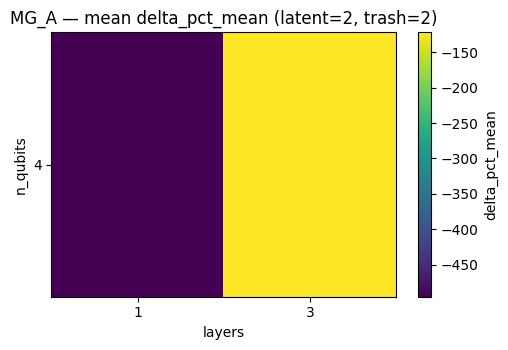

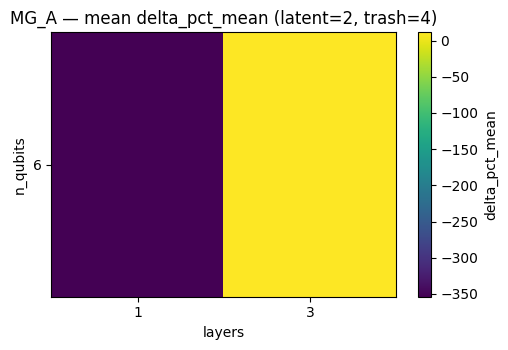

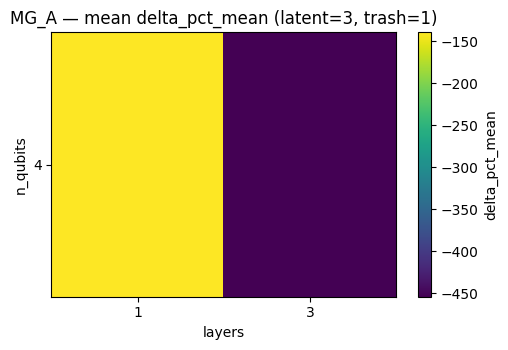

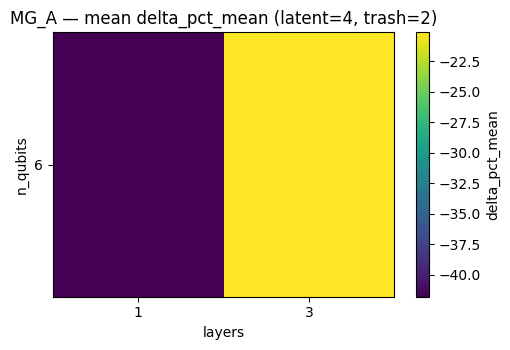

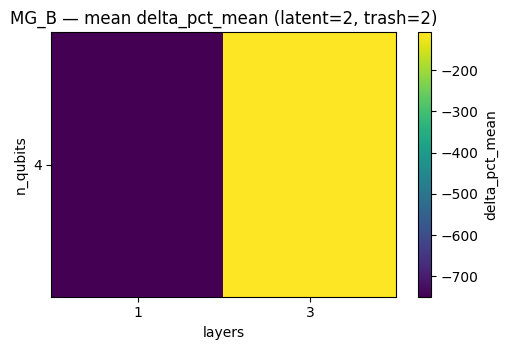

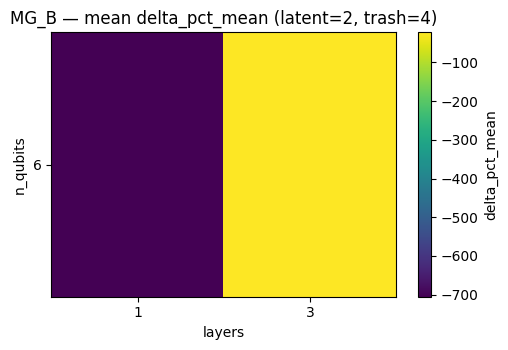

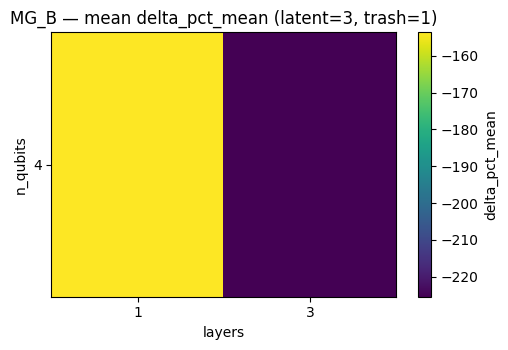

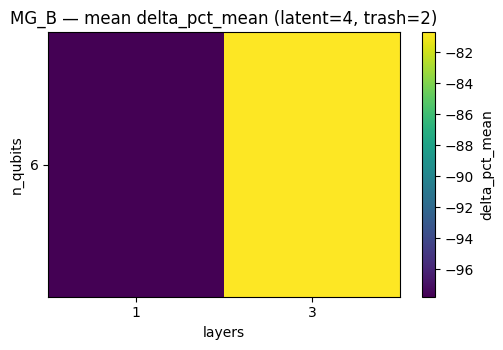

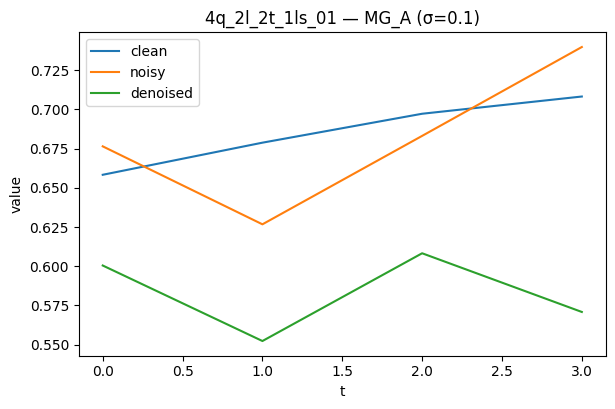

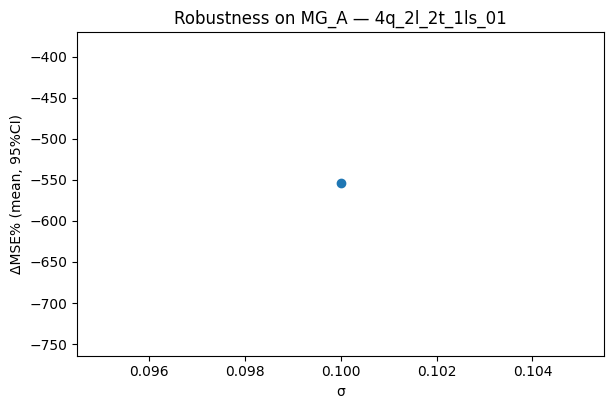

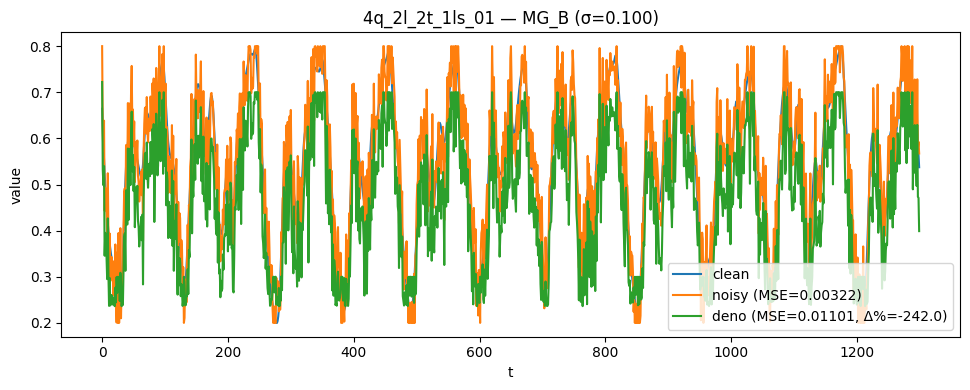

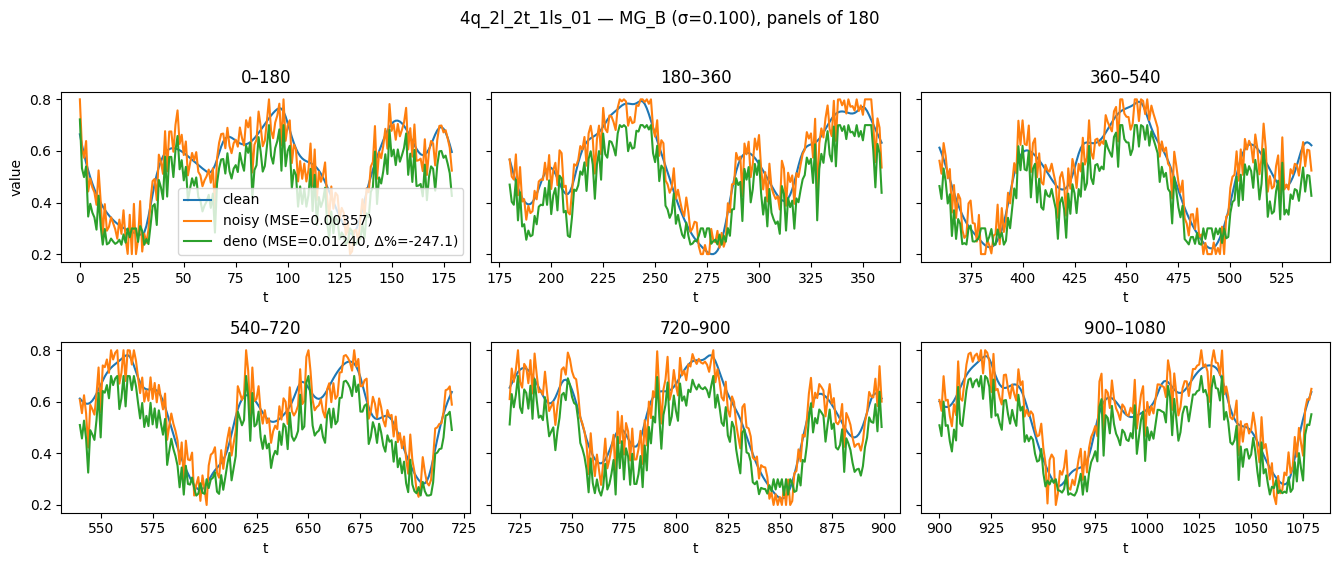

MG_B | 4q_2l_2t_1ls_01 | σ=0.100
Global MSE: noisy=0.00322 deno=0.01101 Δ%=-242.0
Samples improved: 22.9%


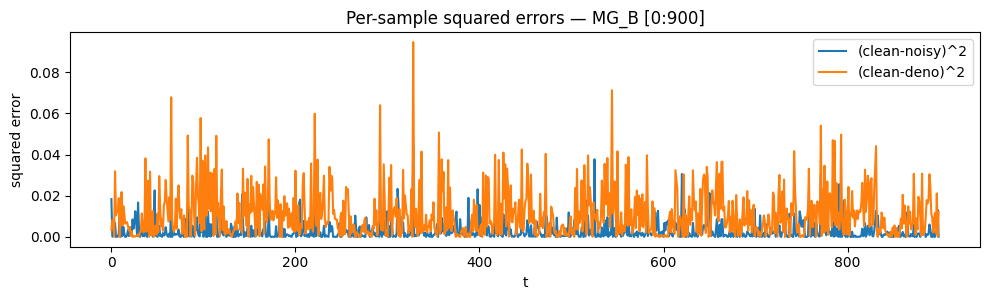

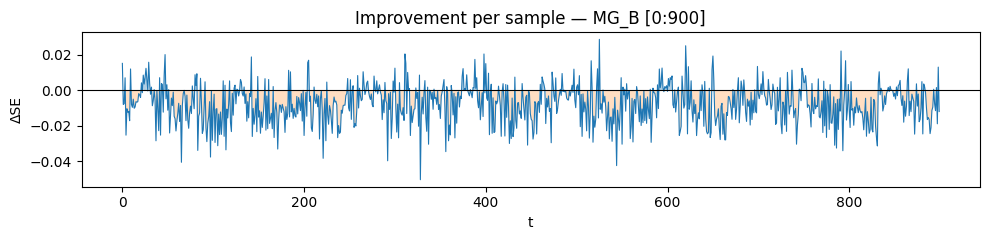

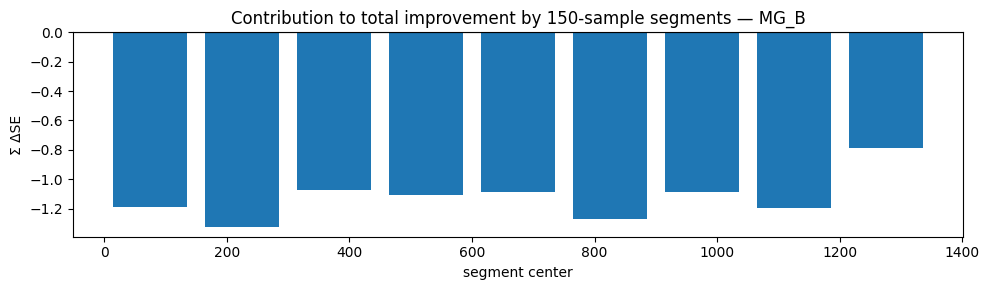

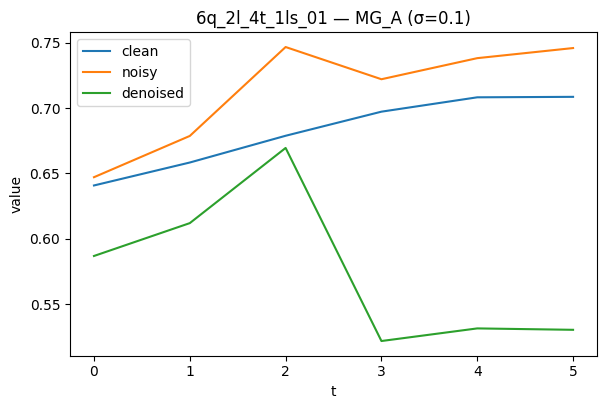

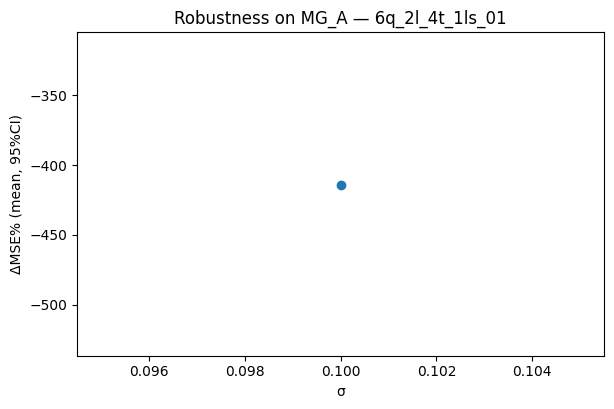

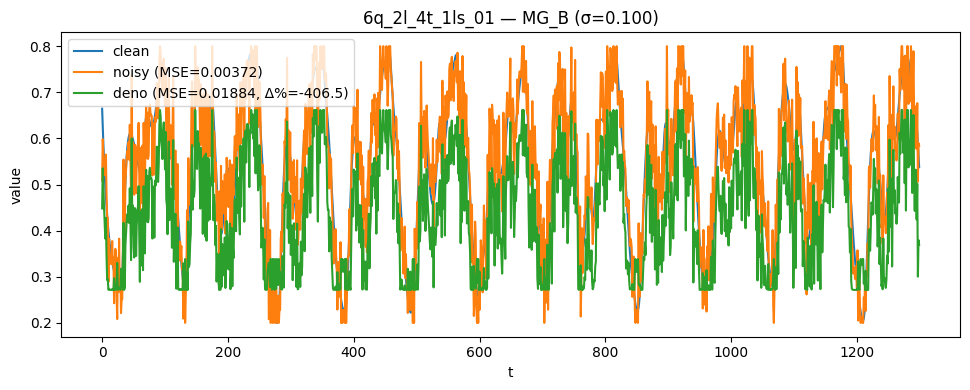

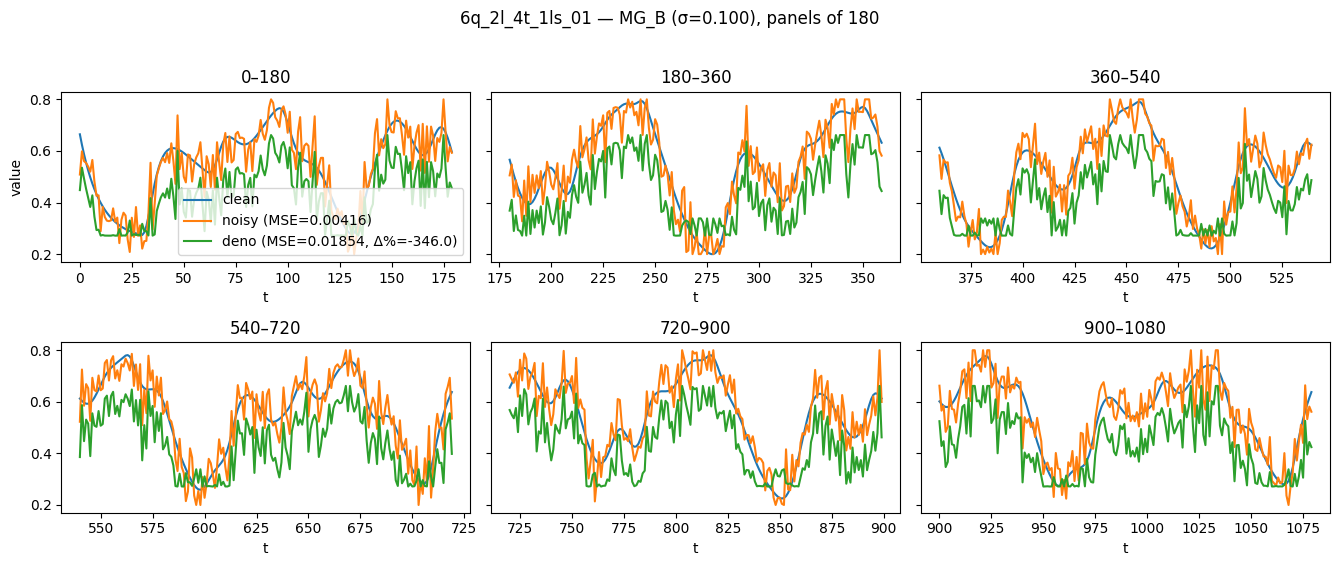

MG_B | 6q_2l_4t_1ls_01 | σ=0.100
Global MSE: noisy=0.00372 deno=0.01884 Δ%=-406.5
Samples improved: 16.4%


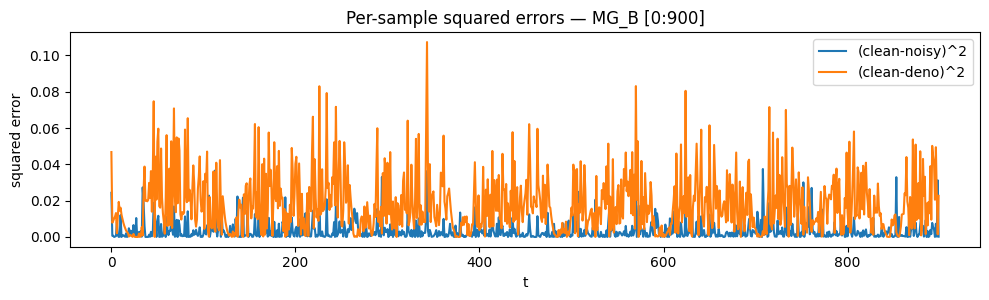

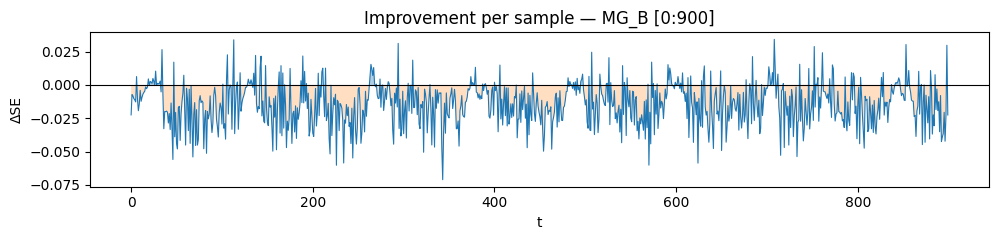

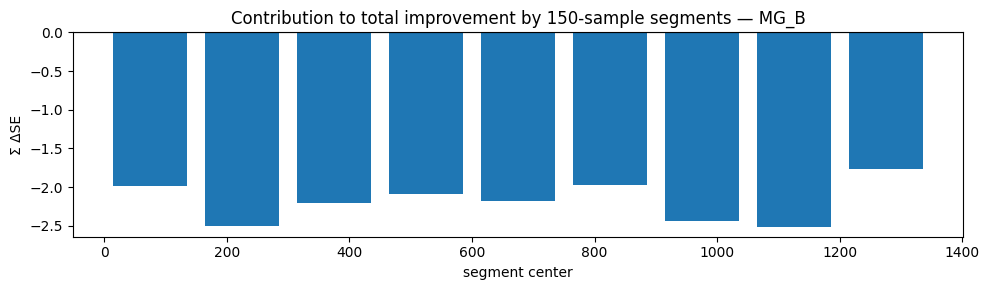

In [9]:
# === Cell 8 — Load models & standard analyses ===============================
REG = load_models_sidekick(MODEL_PATHS)

ALL_RESULTS, ALL_SUMMARIES = run_benchmark(REG, n_eval=N_EVAL_WINDOWS, sigma_override=EVAL_SIGMA)

# Table + quick heatmaps
if REG:
    df = summaries_to_df(ALL_SUMMARIES, REG)
    print("\n== Summary (head) ==")
    print(df.head(12).to_string(index=False))

    for dsname in sorted(ALL_SUMMARIES):
        heatmap_by_arch(df, dsname, value_col="delta_pct_mean")

    # Show a few visuals per window size (first model hitting that size)
    shown=set()
    for name, entry in REG.items():
        w = entry.n_qubits
        if w in shown: continue
        dsname = "MG_A"
        er = ALL_RESULTS[dsname][name]
        plot_reconstruction_example(er, idx=0, title=f"{name} — {dsname} (σ={'model' if EVAL_SIGMA=='model' else EVAL_SIGMA})")
        plot_robustness(entry, DATASETS_BY_W[w][dsname], sigmas=(0.10,), n_eval=N_EVAL_WINDOWS)
        # Full series & panels on MG_B
        rec = reconstruct_full_series(entry, DATASETS_BY_W[w]["MG_B"], sigma_override=EVAL_SIGMA)
        plot_full_series(rec, title=f"{name} — MG_B (σ={rec['sigma']:.3f})")
        plot_full_series_panels(entry, DATASETS_BY_W[w]["MG_B"], sigma_override=EVAL_SIGMA,
                                panel_len=180, ncols=3, nrows=2, start=0, sharey=True)
        error_lens(entry, DATASETS_BY_W[w]["MG_B"], sigma_override=EVAL_SIGMA, seg=150, start=0, length=900)
        shown.add(w)

In [10]:
# === FINAL — Append eval metrics to *all* CSVs + show summaries ==============
import os, glob
import numpy as np
import pandas as pd

# ------------------ 1) Tidy eval frames -------------------------------------
def _eval_long_df(all_summaries, registry):
    rows=[]
    for dsname, bymodel in all_summaries.items():
        for name, sm in bymodel.items():
            e = registry[name]
            rows.append({
                "filename": os.path.basename(e.path),            # e.g., 4q_2l_2t_1ls_01.json
                "model": name,
                "dataset": dsname,                               # MG_A or MG_B
                "n_qubits": e.n_qubits,
                "n_layers": e.meta.get("n_layers", e.params["psi_flat"].size // (e.n_qubits*3)),
                "n_latent": e.n_latent,
                "n_trash": len(e.trash_wires),
                "delta_pct_mean": sm["delta_pct_mean"],
                "success_rate_pct": sm["success_rate_pct"],
                "sign_test_p": sm["sign_test_p"],
                "n_windows": sm["n_windows"],
            })
    return pd.DataFrame(rows)

eval_long = _eval_long_df(ALL_SUMMARIES, REG)
if eval_long.empty:
    raise RuntimeError("No eval summaries collected. Did models load & run?")

# Pivot to one row per filename with columns per dataset
pivot = eval_long.pivot_table(index="filename", columns="dataset",
                              values=["delta_pct_mean","success_rate_pct","sign_test_p"],
                              aggfunc="first")
pivot.columns = [f"{a}_{b}" for a,b in pivot.columns.to_flat_index()]
pivot = pivot.reset_index()

# Also keep a per-model view for on-screen summaries
per_model = (eval_long
             .pivot_table(index=["filename","model"],
                          columns="dataset",
                          values=["delta_pct_mean","success_rate_pct","sign_test_p"],
                          aggfunc="first")
             .reset_index())
per_model.columns = ["_".join([c for c in tup if c]) for tup in per_model.columns.to_flat_index()]

# Helpful composite columns (averages across datasets if both exist)
for base in ["delta_pct_mean","success_rate_pct","sign_test_p"]:
    cols = [c for c in pivot.columns if c.startswith(base+"_")]
    if cols:
        pivot[f"{base}_AVG"] = pivot[cols].mean(axis=1, skipna=True)

print("== Eval (per model file) — head ==")
print(per_model.head(10).to_string(index=False))

# ------------------ 2) Locate ALL relevant CSVs under ARTUR_ROOT -------------
def find_many(root, pattern):
    return sorted(glob.glob(os.path.join(root, "**", pattern), recursive=True))

train_csvs  = find_many(ARTUR_ROOT, "all_training_instances_*.csv")
layer_csvs  = find_many(ARTUR_ROOT, "summary_by_layers_*.csv")

if not train_csvs and not layer_csvs:
    raise FileNotFoundError(f"No training/summary CSVs found under {ARTUR_ROOT}")

print(f"\nFound {len(train_csvs)} training-instance CSV(s) and {len(layer_csvs)} layer-summary CSV(s).")

# ------------------ 3) Merge pivot into EVERY training CSV -------------------
train_outputs = []
for csv_in in train_csvs:
    try:
        df = pd.read_csv(csv_in)
        if "filename" not in df.columns:
            print(f"  ! Skipping (no 'filename' column): {csv_in}")
            continue
        merged = df.merge(pivot, on="filename", how="left")
        # coerce new numeric columns
        for c in merged.columns:
            if any(c.startswith(k) for k in ["delta_pct_mean_","success_rate_pct_","sign_test_p_"]) or c.endswith("_AVG"):
                merged[c] = pd.to_numeric(merged[c], errors="coerce")
        csv_out = csv_in.replace(".csv", "_with_eval.csv")
        merged.to_csv(csv_out, index=False)
        train_outputs.append(csv_out)
        print(f"  ✓ Wrote training+eval → {csv_out}")
    except Exception as e:
        print(f"  ✗ {csv_in}: {e}")

# ------------------ 4) Build per-layer eval aggregates once ------------------
def _mean_std_str(s):
    v = pd.to_numeric(s, errors="coerce").astype(float)
    v = v[np.isfinite(v)]
    return "n/a" if v.size == 0 else f"{v.mean():.6f} ± {v.std(ddof=0):.6f}"

# Prepare layer-level aggregates from the merged training table if available,
# otherwise from eval_long directly.
def build_layer_eval_from_training(csv_path):
    g = pd.read_csv(csv_path)
    if "n_layers" not in g.columns:
        return None
    # try to use merged columns (per dataset) if present
    cols = {
        "delta_MG_A": "delta_pct_mean_MG_A",
        "delta_MG_B": "delta_pct_mean_MG_B",
        "succ_MG_A":  "success_rate_pct_MG_A",
        "succ_MG_B":  "success_rate_pct_MG_B",
        "p_MG_A":     "sign_test_p_MG_A",
        "p_MG_B":     "sign_test_p_MG_B",
    }
    if not all(c in g.columns for c in cols.values()):
        return None
    agg = (g.groupby("n_layers", dropna=False)
             .apply(lambda t: pd.Series({
                 "delta_MG_A": _mean_std_str(t[cols["delta_MG_A"]]),
                 "delta_MG_B": _mean_std_str(t[cols["delta_MG_B"]]),
                 "succ_MG_A":  _mean_std_str(t[cols["succ_MG_A"]]),
                 "succ_MG_B":  _mean_std_str(t[cols["succ_MG_B"]]),
                 "p50_MG_A":   f"{pd.to_numeric(t[cols['p_MG_A']], errors='coerce').median():.6f}",
                 "p50_MG_B":   f"{pd.to_numeric(t[cols['p_MG_B']], errors='coerce').median():.6f}",
             }))
             .reset_index())
    return agg

# Fallback: compute layer aggregates directly from eval_long (uses per-file meta)
def build_layer_eval_from_eval_long():
    # merge in layer info by filename
    info = (eval_long[["filename","n_layers"]]
            .drop_duplicates()
            .set_index("filename"))
    # spread datasets to columns
    wide = eval_long.pivot_table(index="filename",
                                 columns="dataset",
                                 values=["delta_pct_mean","success_rate_pct","sign_test_p"],
                                 aggfunc="first")
    wide.columns = [f"{a}_{b}" for a,b in wide.columns.to_flat_index()]
    wide = wide.reset_index().merge(info, on="filename", how="left")
    def grp_stat(s): return _mean_std_str(s)
    layer_eval = (wide.groupby("n_layers", dropna=False)
                       .apply(lambda t: pd.Series({
                           "delta_MG_A": grp_stat(t.get("delta_pct_mean_MG_A")),
                           "delta_MG_B": grp_stat(t.get("delta_pct_mean_MG_B")),
                           "succ_MG_A":  grp_stat(t.get("success_rate_pct_MG_A")),
                           "succ_MG_B":  grp_stat(t.get("success_rate_pct_MG_B")),
                           "p50_MG_A":   f"{pd.to_numeric(t.get('sign_test_p_MG_A'), errors='coerce').median():.6f}",
                           "p50_MG_B":   f"{pd.to_numeric(t.get('sign_test_p_MG_B'), errors='coerce').median():.6f}",
                       }))
                       .reset_index())
    return layer_eval

# ------------------ 5) Merge into EVERY layer summary CSV --------------------
layer_outputs = []
for csv_in in layer_csvs:
    try:
        # Prefer to derive layer aggregates from a sibling _with_eval file if we created one nearby
        sibling_train = None
        base_dir = os.path.dirname(csv_in)
        cands = [c for c in train_outputs if os.path.dirname(c) == base_dir]
        if cands:
            sibling_train = cands[0]
        layer_eval = (build_layer_eval_from_training(sibling_train)
                      if sibling_train else build_layer_eval_from_eval_long())
        layer_df = pd.read_csv(csv_in)
        if "n_layers" not in layer_df.columns and layer_df.index.name == "n_layers":
            layer_df = layer_df.reset_index()
        merged_layer = layer_df.merge(layer_eval, on="n_layers", how="left")
        csv_out = csv_in.replace(".csv", "_with_eval.csv")
        merged_layer.to_csv(csv_out, index=False)
        layer_outputs.append(csv_out)
        print(f"  ✓ Wrote layer+eval → {csv_out}")
    except Exception as e:
        print(f"  ✗ {csv_in}: {e}")

# ------------------ 6) On-screen summaries -----------------------------------
print("\n== Dataset-level summary ==")
ds_summary = (eval_long
              .groupby("dataset", as_index=False)
              .agg(models=("filename","nunique"),
                   delta_mean=("delta_pct_mean","mean"),
                   delta_median=("delta_pct_mean","median"),
                   succ_mean=("success_rate_pct","mean"),
                   succ_median=("success_rate_pct","median"),
                   p_median=("sign_test_p","median"))
              .sort_values("dataset"))
# Pretty rounding
for c in ["delta_mean","delta_median","succ_mean","succ_median","p_median"]:
    ds_summary[c] = ds_summary[c].round(6)
print(ds_summary.to_string(index=False))

print("\n== Top models by average Δ% across datasets ==")
avg_cols = [c for c in pivot.columns if c.startswith("delta_pct_mean_")]
top_models = (pivot[["filename"] + avg_cols]
              .assign(avg_delta=lambda d: d[avg_cols].mean(axis=1, skipna=True))
              .sort_values("avg_delta", ascending=False)
              .head(12))
print(top_models.to_string(index=False))

# ------------------ 7) Show the new CSVs (heads) -----------------------------
def show_heads(paths, title):
    if not paths: 
        return
    print(f"\n== {title} (showing up to 2) ==")
    for p in paths[:2]:
        df = pd.read_csv(p)
        print(f"\n-- {p} --")
        cols = [c for c in df.columns if "delta_pct_mean" in c or "success_rate_pct" in c or "sign_test_p" in c]
        keep = (["filename","n_layers","model","dataset"] if set(["model","dataset"]).issubset(df.columns) else ["filename","n_layers"])
        keep = [c for c in keep if c in df.columns] + cols[:6]  # a few eval cols
        print(df[keep].head(10).to_string(index=False))

show_heads(train_outputs, "Merged training CSVs")
show_heads(layer_outputs, "Merged layer-summary CSVs")

== Eval (per model file) — head ==
            filename           model  delta_pct_mean_MG_A  delta_pct_mean_MG_B  sign_test_p_MG_A  sign_test_p_MG_B  success_rate_pct_MG_A  success_rate_pct_MG_B
4q_2l_2t_1ls_01.json 4q_2l_2t_1ls_01          -553.734924          -862.268396          0.000002          0.000402                    0.0                   10.0
4q_2l_2t_1ls_02.json 4q_2l_2t_1ls_02          -600.370998          -943.142988          0.000002          0.000402                    0.0                   10.0
4q_2l_2t_1ls_03.json 4q_2l_2t_1ls_03          -378.221967          -534.362867          0.000002          0.002577                    0.0                   15.0
4q_2l_2t_1ls_04.json 4q_2l_2t_1ls_04          -472.090602          -701.393366          0.000002          0.000402                    0.0                   10.0
4q_2l_2t_1ls_05.json 4q_2l_2t_1ls_05          -473.120081          -704.189847          0.000002          0.000402                    0.0                   10.0

C:\Users\artur\AppData\Local\Temp\ipykernel_3844\3060258344.py:112: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda t: pd.Series({
C:\Users\artur\AppData\Local\Temp\ipykernel_3844\3060258344.py:112: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda t: pd.Series({
C:\Users\artur\AppData\Local\Temp\ipykernel_3844\3060258344.py:112: DeprecationWarning: DataFrameGroupBy.apply operated on t

In [18]:
import os, pandas as pd, numpy as np
from pathlib import Path

# ---- 1) Explicit CSVs you gave --------------------------------------------
CSV_PATHS = [
    "runs_halfqae/all_training_instances_v5_with_eval.csv",
]
missing = [p for p in CSV_PATHS if not os.path.exists(p)]
if missing:
    raise FileNotFoundError(f"These CSVs were not found:\n  " + "\n  ".join(missing))

print("Loading CSVs:")
for p in CSV_PATHS: print(" •", p)
df_all = pd.concat([pd.read_csv(p, low_memory=False) for p in CSV_PATHS], ignore_index=True)

# ---- 2) Derived/guard columns ---------------------------------------------
def _config_name_of(row):
    return f"{int(row['n_qubits'])}q_{int(row['n_latent'])}l_{int(row['n_trash'])}t_{int(row['n_layers'])}ls"

df_all = df_all.copy()
if "config_name" not in df_all.columns:
    df_all["config_name"] = df_all.apply(_config_name_of, axis=1)

# Compute AVGs if not present
if "delta_pct_mean_AVG" not in df_all.columns and {"delta_pct_mean_MG_A","delta_pct_mean_MG_B"} <= set(df_all.columns):
    df_all["delta_pct_mean_AVG"] = df_all[["delta_pct_mean_MG_A","delta_pct_mean_MG_B"]].mean(axis=1)
if "success_rate_pct_AVG" not in df_all.columns and {"success_rate_pct_MG_A","success_rate_pct_MG_B"} <= set(df_all.columns):
    df_all["success_rate_pct_AVG"] = df_all[["success_rate_pct_MG_A","success_rate_pct_MG_B"]].mean(axis=1)
if "sign_test_p_AVG" not in df_all.columns:
    df_all["sign_test_p_AVG"] = pd.NA  # leave blank unless you already computed a combined p

# Quick sanity
counts = df_all.groupby("config_name", dropna=False)["instance_id"].nunique().sort_values()
print("\nInstances per config (unique instance_id):")
print(counts.to_string())

# ---- 3) Pick the “middle” instance per config -----------------------------
perf_col = "delta_pct_mean_AVG"      # primary ranking: closeness to median of this
p_col    = "sign_test_p_AVG"         # tie-breaker 1 (smaller better) if available
succ_col = "success_rate_pct_AVG"    # tie-breaker 2 (closer to median)

middle_rows = []
for cfg, g in df_all.groupby("config_name", dropna=False):
    g2 = g.dropna(subset=[perf_col]).copy()
    if g2.empty:
        continue
    med = g2[perf_col].median()
    g2["_dist"] = (g2[perf_col] - med).abs()
    if succ_col in g2:
        g2["_succ_dist"] = (g2[succ_col] - g2[succ_col].median()).abs()

    sort_cols, ascending = ["_dist"], [True]
    if p_col in g2.columns:      sort_cols.append(p_col);       ascending.append(True)
    if "_succ_dist" in g2.columns: sort_cols.append("_succ_dist"); ascending.append(True)
    sort_cols.append("filename"); ascending.append(True)  # deterministic final tie-break

    pick = g2.sort_values(sort_cols, ascending=ascending).iloc[0]
    middle_rows.append(pick.drop(labels=[c for c in ["_dist","_succ_dist"] if c in g2.columns]))

middle_df = pd.DataFrame(middle_rows).reset_index(drop=True)

# ---- 4) Save alongside -------------------------------------
out_dir = Path("Jacob") if Path("Jacob").exists() else Path(CSV_PATHS[0]).parent
out_dir.mkdir(parents=True, exist_ok=True)
OUT_CSV = out_dir / "representative_middle_models_with_eval.csv"
middle_df.to_csv(OUT_CSV, index=False)

# ---- 5) Display compact summary -------------------------------------------
show_cols = [
    "config_name","filename","run_tag",
    "delta_pct_mean_MG_A","delta_pct_mean_MG_B","delta_pct_mean_AVG",
    "success_rate_pct_MG_A","success_rate_pct_MG_B","success_rate_pct_AVG",
    "sign_test_p_MG_A","sign_test_p_MG_B","sign_test_p_AVG",
    "total_train_seconds"
]
available_cols = [c for c in show_cols if c in middle_df.columns]
print(f"\nSaved {len(middle_df)} representatives → {OUT_CSV}")
display(middle_df.sort_values("config_name")[available_cols])

Loading CSVs:
 • runs_halfqae/all_training_instances_v5_with_eval.csv

Instances per config (unique instance_id):
config_name
6q_4l_2t_1ls    5
6q_4l_2t_3ls    5

Saved 2 representatives → runs_halfqae\representative_middle_models_with_eval.csv


,config_name,filename,run_tag,delta_pct_mean_MG_A,delta_pct_mean_MG_B,delta_pct_mean_AVG,success_rate_pct_MG_A,success_rate_pct_MG_B,success_rate_pct_AVG,sign_test_p_MG_A,sign_test_p_MG_B,sign_test_p_AVG,total_train_seconds
0,6q_4l_2t_1ls,6q_4l_2t_1ls_04.json,inst4_L1,-43.990923,-99.497408,-71.744166,40.0,25.0,32.5,0.503445,0.041389,0.272417,588.942944
1,6q_4l_2t_3ls,6q_4l_2t_3ls_04.json,inst4_L3,-26.047561,-80.503762,-53.275662,45.0,45.0,45.0,0.823803,0.823803,0.823803,3605.973515


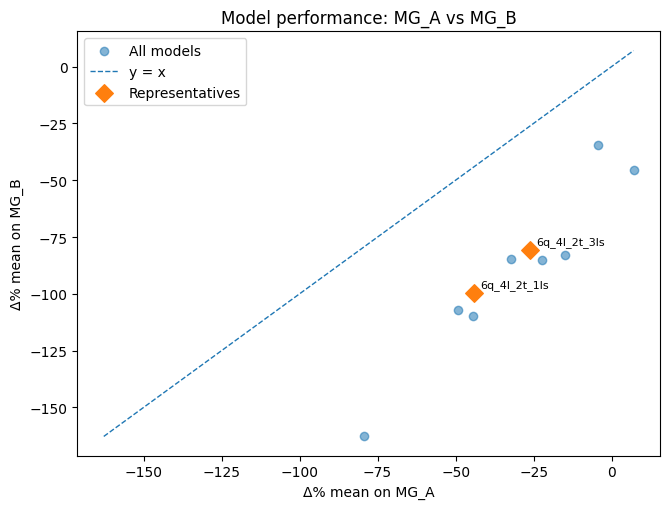

Correlation (Δ% MG_A vs MG_B, all models): r = 0.959
Points above diagonal (MG_B > MG_A): 0
Points below diagonal (MG_B < MG_A): 10
On diagonal: 0

Representatives — MG_A vs MG_B:


,config_name,filename,run_tag,delta_pct_mean_MG_A,delta_pct_mean_MG_B,delta_pct_mean_AVG
0,6q_4l_2t_1ls,6q_4l_2t_1ls_04.json,inst4_L1,-43.990923,-99.497408,-71.744166
1,6q_4l_2t_3ls,6q_4l_2t_3ls_04.json,inst4_L3,-26.047561,-80.503762,-53.275662



Largest MG_A–MG_B disparities (abs gap, all models):


,config_name,filename,run_tag,delta_pct_mean_MG_A,delta_pct_mean_MG_B,_gap_AB
0,6q_4l_2t_1ls,6q_4l_2t_1ls_01.json,inst1_L1,-79.361561,-162.747704,83.386143
6,6q_4l_2t_3ls,6q_4l_2t_3ls_02.json,inst2_L3,-14.934473,-82.777439,67.842966
5,6q_4l_2t_3ls,6q_4l_2t_3ls_01.json,inst1_L3,-44.304088,-109.811044,65.506956
7,6q_4l_2t_3ls,6q_4l_2t_3ls_03.json,inst3_L3,-22.272919,-85.085583,62.812664
1,6q_4l_2t_1ls,6q_4l_2t_1ls_02.json,inst2_L1,-49.121444,-107.139957,58.018513
3,6q_4l_2t_1ls,6q_4l_2t_1ls_04.json,inst4_L1,-43.990923,-99.497408,55.506485
8,6q_4l_2t_3ls,6q_4l_2t_3ls_04.json,inst4_L3,-26.047561,-80.503762,54.456201
9,6q_4l_2t_3ls,6q_4l_2t_3ls_05.json,inst5_L3,7.013398,-45.373674,52.387073
4,6q_4l_2t_1ls,6q_4l_2t_1ls_05.json,inst5_L1,-32.388973,-84.742166,52.353192
2,6q_4l_2t_1ls,6q_4l_2t_1ls_03.json,inst3_L1,-4.230668,-34.671922,30.441254


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

assert "df_all" in globals(), "Run Cell A first to load df_all."

# Scatter: all points
x = pd.to_numeric(df_all["delta_pct_mean_MG_A"], errors="coerce").values
y = pd.to_numeric(df_all["delta_pct_mean_MG_B"], errors="coerce").values

plt.figure(figsize=(6.8, 5.2))
plt.scatter(x, y, alpha=0.55, label="All models")

# Diagonal guide
finite = np.isfinite(x) & np.isfinite(y)
xmin = float(np.min(np.concatenate([x[finite], y[finite]])))
xmax = float(np.max(np.concatenate([x[finite], y[finite]])))
plt.plot([xmin, xmax], [xmin, xmax], linestyle="--", linewidth=1.0, label="y = x")

plt.xlabel("Δ% mean on MG_A")
plt.ylabel("Δ% mean on MG_B")
plt.title("Model performance: MG_A vs MG_B")

# Overlay representatives
if "middle_df" in globals() and len(middle_df):
    xr = pd.to_numeric(middle_df["delta_pct_mean_MG_A"], errors="coerce").values
    yr = pd.to_numeric(middle_df["delta_pct_mean_MG_B"], errors="coerce").values
    plt.scatter(xr, yr, s=80, marker="D", label="Representatives")
    for _, r in middle_df.dropna(subset=["delta_pct_mean_MG_A","delta_pct_mean_MG_B"]).iterrows():
        plt.annotate(r["config_name"], (float(r["delta_pct_mean_MG_A"]), float(r["delta_pct_mean_MG_B"])),
                     xytext=(4, 4), textcoords="offset points", fontsize=8)

plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Numeric summary
def _safe_corr(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    m = np.isfinite(a) & np.isfinite(b)
    return np.corrcoef(a[m], b[m])[0,1] if m.sum() >= 3 else np.nan

corr_all = _safe_corr(x, y)
above = int(np.nansum(y > x))
below = int(np.nansum(y < x))
equal = int(np.nansum(np.isclose(y, x, atol=1e-9)))
print(f"Correlation (Δ% MG_A vs MG_B, all models): r = {corr_all:.3f}")
print(f"Points above diagonal (MG_B > MG_A): {above}")
print(f"Points below diagonal (MG_B < MG_A): {below}")
print(f"On diagonal: {equal}")

# Per-config comparison table (representatives if available, else all-model medians)
if "middle_df" in globals() and len(middle_df):
    comp = (middle_df[["config_name","filename","run_tag",
                       "delta_pct_mean_MG_A","delta_pct_mean_MG_B","delta_pct_mean_AVG"]]
            .sort_values("config_name"))
    print("\nRepresentatives — MG_A vs MG_B:")
    display(comp)
else:
    med = (df_all.groupby("config_name")[["delta_pct_mean_MG_A","delta_pct_mean_MG_B"]]
                 .median().reset_index())
    med["delta_pct_mean_AVG"] = med[["delta_pct_mean_MG_A","delta_pct_mean_MG_B"]].mean(axis=1)
    print("\nGroup medians (no representatives found in scope):")
    display(med.sort_values("config_name"))

# Biggest MG_A–MG_B gaps (all models)
df_all["_gap_AB"] = df_all["delta_pct_mean_MG_A"] - df_all["delta_pct_mean_MG_B"]
disp_cols = ["config_name","filename","run_tag","delta_pct_mean_MG_A","delta_pct_mean_MG_B","_gap_AB"]
print("\nLargest MG_A–MG_B disparities (abs gap, all models):")
display(df_all.reindex(df_all["_gap_AB"].abs().sort_values(ascending=False).index)
               [disp_cols].head(10))